In [227]:
import numpy as np
import skimage
import os
from sklearn import mixture
import scipy.stats
import matplotlib.pyplot as plt
import cv2

## Exercise 1

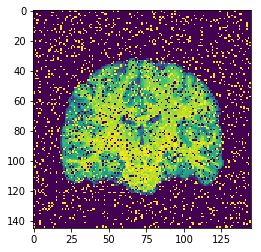

In [228]:
filename = os.path.join('brain-noisy.png')
brain = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
#brain = skimage.io.imread(filename)
plt.imshow(brain)
plt.show()#skimage.io.imshow(brain)

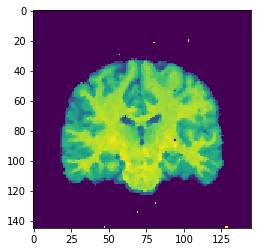

In [229]:
# Subtask a
brain_denoised = cv2.medianBlur(brain, 3)
plt.imshow(brain_denoised)
plt.show()

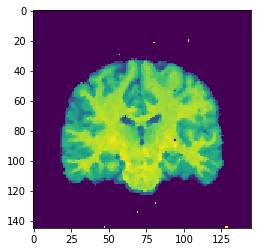

In [246]:
# Subtask b
ret, mask = cv2.threshold(brain_denoised, 2, 255, cv2.THRESH_BINARY)
plt.imshow(cv2.bitwise_and(brain_denoised, mask))
plt.show()

In [247]:
brain_masked_flat = brain_denoised[mask > 0]

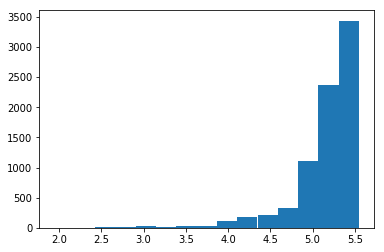

In [248]:
# Subtask c
brain_log = np.log1p(brain_masked_flat)
plt.hist(brain_log, bins=15)
plt.show()

- Peak represent different materials in the brain image
- three different materials are detecatble here

Num points: 7872,
Intial means: [  6.  127.5 255. ],
std. deviation: [11355.93026063  1009.11979121 14686.96788919],
mixing coeff.: [0.49669715 0.49822154 0.50482724]
0> Means: [  6.  127.5 255. ], std. deviation: [11355.93026063  1009.11979121 14686.96788919], mixing coeff.: [0.49669715 0.49822154 0.50482724]


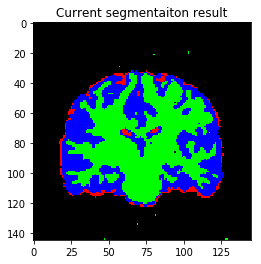

50> Means: [ 90.42774279 167.62050646 220.83909945], std. deviation: [1406.27305133  382.55329061  136.93302867], mixing coeff.: [0.14331785 0.41641974 0.4402624 ]


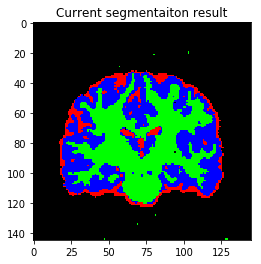

100> Means: [ 86.07347219 167.58571344 221.0795712 ], std. deviation: [1230.48118031  419.28831963  133.30296622], mixing coeff.: [0.13238034 0.43406603 0.43355363]


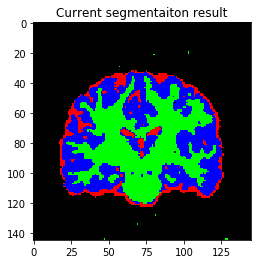

In [ ]:
# Subtask d
def calc_norm(x, impact, mean, deviation):
    part1 = 1.0 / np.sqrt(2 * np.pi * deviation)
    part2 = np.exp(-1.0 * ((x - mean)**2 / (2 * deviation)))
    res = impact * part1 * part2
   
    return res if not np.isnan(res) else 0.0

def visualize(rho, image):
    blank_image = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
    i = 0
    values = [(255, 0, 0), (0, 0, 255), (0, 255, 0)]
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            value = image[y, x]
            if value <= 1:
                continue
            blank_image[y, x] = values[np.argmax(rho[i])]
            i += 1
    plt.imshow(blank_image)
    plt.title('Current segmentaiton result')
    plt.show()
    
def init_gmm(data, num_clusters=3):
    num_points = len(data)
    mem_vecs = np.zeros((num_points, num_clusters))
    
    for dp in range(mem_vecs.shape[0]):
        for cluster_mem in range(mem_vecs.shape[1]):
            if np.random.randint(0, 2):
                mem_vecs[dp, cluster_mem] = 1
                continue

    mix_coeff = np.sum(mem_vecs, axis=0) / num_points 
    means = np.array([data.min(), data.max()/2, data.max()])
    devs = np.random.uniform(0, (data.max()/2)**2, num_clusters)
    rho = np.zeros((num_points, num_clusters))

    print(f'Num points: {num_points},\nIntial means: {means},\nstd. deviation: {devs},\nmixing coeff.: {mix_coeff}') 
    return mix_coeff, means, devs, rho
    
def e_step(data, coeffs, means, devs, rho):
    for d in range(num_points):
        cluster_sum = 0
        for c in range(num_clusters):
            rho[d][c] = calc_norm(data[d], coeffs[c], means[c], devs[c])
            cluster_sum += rho[d][c]
        rho[d] /= cluster_sum
    return rho

def m_step(data, coeffs, means, devs, rho):
    N_k = np.sum(rho, axis=0)
    for c in range(num_clusters):
        means[c] = sum([data[d] * rho[d, c] for d in range(num_points)]) / N_k[c]
        devs[c] = sum([rho[d, c] * (data[d] - means[c])**2 for d in range(num_points)]) / N_k[c]
        coeffs[c] = N_k[c] / num_points

    return coeffs, means, devs

num_iterations = 200
min_change = 0.0001
old_means, old_devs = [], []
num_clusters = 3
mix_coeff, means, devs, rho = init_gmm(brain_masked_flat)

for iteration in range(num_iterations):
    # E-Step
    rho = e_step(brain_masked_flat, mix_coeff, means, devs, rho)
    
    # Visualization
    if iteration % (num_iterations / 4) == 0:
        print(f'{iteration}> Means: {means}, std. deviation: {devs}, mixing coeff.: {mix_coeff}')
        visualize(rho, brain_denoised)
    
    # M-Step
    old_means.append(np.copy(means))
    old_devs.append(np.copy(devs))
    mix_coeff, means, devs = m_step(brain_masked_flat, mix_coeff, means, devs, rho)
    
    # Termination criteria
    if np.abs(old_devs[-1] - devs).sum() < min_change:
        break

In [ ]:
visualize(rho, brain_denoised)

plt.plot(old_means)
plt.ylabel('Gaussian means')
plt.xlabel('Iteration')
plt.title('Training curve')
plt.show()